In [1]:
import sys

sys.executable.split('/')[-3] == 'cda_venv'

True

In [1]:
import os
import random
import sys
import time
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled

from tqdm import tqdm

sys.path.append('./')
from src.utils import *

tqdm.pandas()
warnings.filterwarnings('ignore')

seed_value = 2021
random.seed(seed_value)
np.random.seed(seed_value)

## Paths handling

In [2]:
data_dir = 'data/imclef07d'

train_file = 'imclef07d_train'
test_file = 'imclef07d_test'
# NOTE: imclef07d.hf == imclef07d_train.hf == imclef07d_test.hf
data_hf_file = 'imclef07d.hf'

## Class hierarchy

In [3]:
G = nx.DiGraph()

with open(file_path(data_hf_file), "r") as f:
    for line in f:
        v1, v2 = line.replace('\n', '').split(' ')
        G.add_edge(v1, v2)

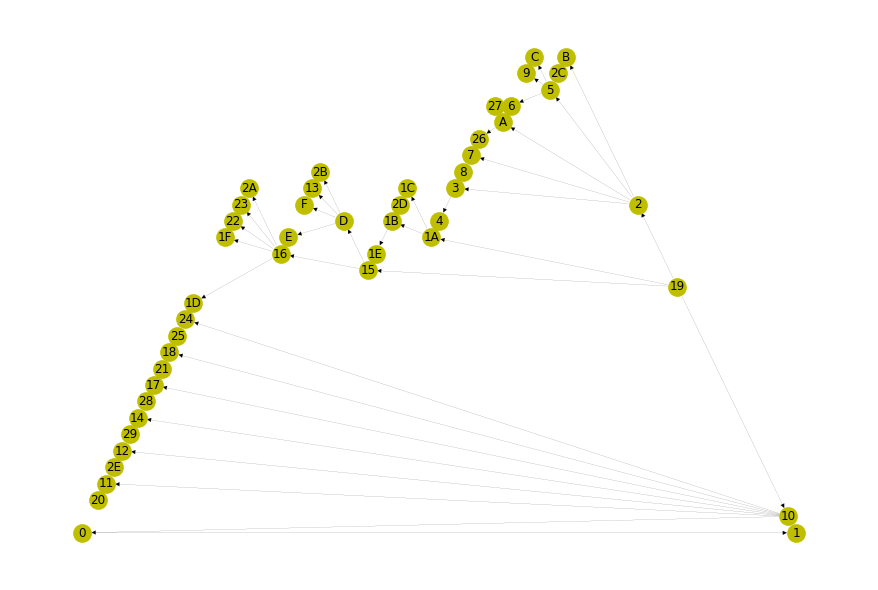

In [4]:
plt.figure(figsize=(12, 8))

nx.draw(
    G, 
    pos = nx.planar_layout(G), # planar_layout, spring_layout
    node_size=350,
    linewidths=0,
    width=0.1,
    node_color='y',
    with_labels=True
)

plt.show()

In [5]:
tree_data = nx.tree_data(G, '19')
# tree_data

In [6]:
class_hierarchy = get_class_hierarchy(tree_data)

class_hierarchy

{'15': ['16', 'D'],
 '16': ['1D', '1F', '22', '23', '2A'],
 'D': ['E', 'F', '13', '2B'],
 '1A': ['1B', '1C'],
 '1B': ['1E'],
 '1C': ['2D'],
 '2': ['3', '7', 'A', '5', 'B'],
 '3': ['4'],
 '7': ['8'],
 'A': ['26', '27'],
 '5': ['6', '9', 'C'],
 'B': ['2C'],
 '10': ['11', '12', '14', '17', '18', '0', '24'],
 '11': ['20'],
 '12': ['2E'],
 '14': ['29'],
 '17': ['28'],
 '18': ['21'],
 '0': ['1'],
 '24': ['25'],
 '<ROOT>': ['15', '1A', '2', '10']}

## Dataframes

In [7]:
with open(file_path(train_file), 'r') as f1, \
     open(file_path(train_file, add_csv=True), 'w+') as f2:
    f1_lines = f1.readlines()
    header = 'labels;' + str(list(range(1,81))).strip('[]').replace(' ', '').replace(',', ';') + '\n'
    f2.write(header)
    for line in f1_lines:
        line_split = line.split()
        new_line = line_split[0]
        for el in line_split[1:]:
            new_line = new_line + ';' + el.split(':')[1]
        f2.write(new_line + '\n')

In [8]:
df_train = pd.read_csv(file_path(train_file, add_csv=True), sep=';')

# df_train_agg = df_train.groupby(['labels']).size().to_frame('count').reset_index()
df_train_cp = df_train.copy(deep=True)

df_train['labels'] = df_train['labels'].apply(lambda x: x.split(','))

In [9]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 81 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   labels  10000 non-null  object 
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null  float64
 22 

,labels,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,"[15, D, 2B]",0.596529,-0.284171,0.254657,-0.162900,-0.007383,0.009371,-0.024586,-0.132000,-0.487257,...,0.227743,0.210829,0.523171,0.275814,0.708057,0.174729,0.007300,0.440557,-0.407543,0.166243
1,"[15, D, 2B]",0.025100,0.001543,0.397514,0.122814,-0.007383,-0.133486,0.403986,0.010857,0.084171,...,0.227743,0.353686,0.380314,0.275814,0.422343,0.317586,-0.135557,0.154843,0.592457,0.166243
2,"[15, D, 2B]",-0.260614,0.001543,0.540371,0.408529,-0.007383,0.009371,0.118271,0.010857,0.084171,...,0.227743,0.210829,0.237457,0.418671,0.422343,0.174729,0.007300,0.583414,0.306743,0.023386
3,"[15, D, 2B]",-0.403471,-0.284171,0.111800,-0.162900,0.159283,-0.133486,-0.024586,-0.132000,0.227029,...,-0.200829,0.210829,0.237457,-0.295614,-0.149086,-0.396700,0.007300,0.726271,-0.121829,0.023386
4,"[15, D, 2B]",0.167957,-0.141314,0.254657,0.122814,-0.007383,-0.419200,0.118271,-0.560571,-0.344400,...,0.084886,-0.074886,0.380314,0.418671,-0.006229,-0.539557,-0.135557,0.011986,-0.264686,-0.119471


In [10]:
with open(file_path(test_file), 'r') as f1, \
     open(file_path(test_file, add_csv=True), 'w+') as f2:
    f1_lines = f1.readlines()
    header = 'labels;' + str(list(range(1,81))).strip('[]').replace(' ', '').replace(',', ';') + '\n'
    f2.write(header)
    for line in f1_lines:
        line_split = line.split()
        new_line = line_split[0]
        for el in line_split[1:]:
            new_line = new_line + ';' + el.split(':')[1]
        f2.write(new_line + '\n')

In [11]:
df_test = pd.read_csv(file_path(test_file, add_csv=True), sep=';')
df_test['labels'] = df_test['labels'].apply(lambda x: x.split(','))

In [12]:
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 81 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   labels  1006 non-null   object 
 1   1       1006 non-null   float64
 2   2       1006 non-null   float64
 3   3       1006 non-null   float64
 4   4       1006 non-null   float64
 5   5       1006 non-null   float64
 6   6       1006 non-null   float64
 7   7       1006 non-null   float64
 8   8       1006 non-null   float64
 9   9       1006 non-null   float64
 10  10      1006 non-null   float64
 11  11      1006 non-null   float64
 12  12      1006 non-null   float64
 13  13      1006 non-null   float64
 14  14      1006 non-null   float64
 15  15      1006 non-null   float64
 16  16      1006 non-null   float64
 17  17      1006 non-null   float64
 18  18      1006 non-null   float64
 19  19      1006 non-null   float64
 20  20      1006 non-null   float64
 21  21      1006 non-null   float64
 22  

,labels,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,"[15, D, 2B]",-0.208179,-0.260721,0.531241,-0.314825,-0.012757,-0.261573,0.290116,0.445754,-0.359273,...,-0.052400,0.643283,0.374751,0.428287,0.332671,-0.245385,0.297785,0.720676,0.451008,0.433598
1,"[15, D, 2B]",0.077535,-0.117864,-0.040187,-0.171968,-0.179423,0.166998,0.147259,0.445754,-0.073559,...,0.376172,0.214712,0.231894,0.571145,0.332671,-0.388242,0.012070,0.434962,-0.406135,0.433598
2,"[15, D, 2B]",0.077535,0.167850,-0.040187,-0.029111,-0.012757,-0.261573,0.147259,-0.411389,-0.073559,...,0.233314,0.357569,0.517609,0.428287,0.666004,0.183187,0.012070,0.149247,0.165294,0.233598
3,"[15, D, 2B]",-0.065322,-0.117864,-0.183045,0.542318,0.153910,0.024141,0.004402,0.017183,-0.216416,...,0.090457,0.071855,0.231894,0.571145,0.499337,-0.531099,0.012070,0.149247,-0.406135,0.033598
4,"[15, D, 2B]",0.648963,0.024993,-0.040187,-0.029111,0.320577,0.309855,-0.281312,-0.268532,-0.502130,...,0.519029,-0.071003,-0.053820,-0.000284,-0.000663,-0.388242,0.012070,-0.279324,-0.406135,-0.166402


### Labels countplot

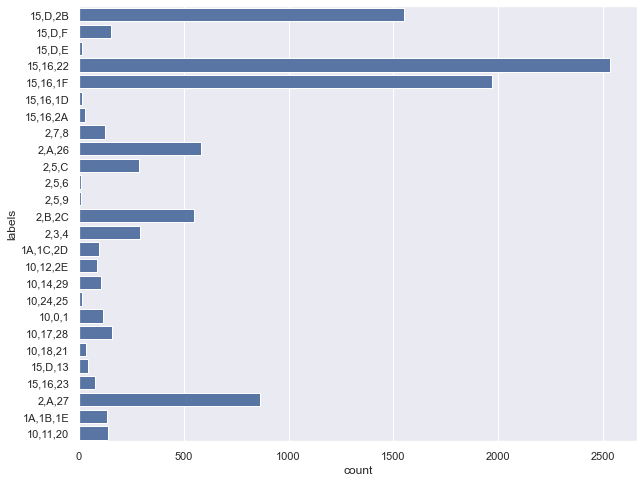

In [15]:
sns.set(
    rc={'figure.figsize':(10, 8)}, 
    style="darkgrid"
)

chart = sns.countplot(
    y="labels", 
    data=df_train_cp, 
    color='b'
)

plt.show()

## Data preparation

In [13]:
# Train
y_train = df_train['labels']
x_train = df_train.drop(columns=['labels'])
# Test
y_test = df_test['labels']
x_test = df_test.drop(columns=['labels'])

train_ds = (x_train, y_train)
test_ds = (x_test, y_test)

## Hierarchical classification

based on: [link](https://github.com/globality-corp/sklearn-hierarchical-classification/blob/develop/examples/classify_digits.py)

In [14]:
base_estimator = make_pipeline(
    TruncatedSVD(n_components=30),
    RandomForestClassifier(random_state=seed_value)
)

# get graph
clf_lcpn = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    algorithm='lcpn'
)
# clf_lcpn.fit(x_train[:10], y_train.apply(lambda x: x[-1])[:10])
clf_lcpn.fit(x_train, y_train.apply(lambda x: x[-1]))

graph = clf_lcpn.graph_

### LCN - Local Classifier per Node

In [20]:
lcn_hc(
    train_ds=train_ds,
    test_ds=test_ds,
    class_hierarchy=class_hierarchy,
    graph=graph,
    base_estimator=base_estimator
)

{'h_fbeta': 0.7498090145148969}

### LCPL - Local Classifier per Level

In [21]:
lcpl_hc(
    train_ds=train_ds,
    test_ds=test_ds,
    class_hierarchy=class_hierarchy,
    graph=graph,
    base_estimator=base_estimator
)

{'h_fbeta': 0.7906305150008021}

### LCPN - Local Classifier per Parent Node

In [22]:
lcpn_hc(
    train_ds=train_ds,
    test_ds=test_ds,
    class_hierarchy=class_hierarchy,
    graph=graph,
    base_estimator=base_estimator
)

{'h_fbeta': 0.8311965811965811}

### Big-Bang

In [23]:
big_bang_hc(
    train_ds=train_ds,
    test_ds=test_ds,
    class_hierarchy=class_hierarchy,
    graph=graph,
    base_estimator=base_estimator
)

{'h_fbeta': 0.7295178361426892}

## Flat

In [24]:
flat_hc(
    train_ds=train_ds,
    test_ds=test_ds,
    class_hierarchy=class_hierarchy,
    graph=graph,
    base_estimator=base_estimator
)

{'h_fbeta': 0.8430702858170053}

## Experiments

In [15]:
base_estimator_1 = make_pipeline(
    TruncatedSVD(n_components=30),
    SVC(
        gamma='scale',
        kernel="sigmoid",
        probability=True,
        random_state=seed_value
    )
)

base_estimator_2 = make_pipeline(
    TruncatedSVD(n_components=30),
    RandomForestClassifier(random_state=seed_value)
)

base_estimator_3 = make_pipeline(
    TruncatedSVD(n_components=30),
    AdaBoostClassifier(random_state=seed_value)
)

base_estimators_dict = {
    'TruncatedSVD - SVC': base_estimator_1,
    'TruncatedSVD - RandomForestClassifier': base_estimator_2,
    'TruncatedSVD - AdaBoostClassifier': base_estimator_3
}

clf_func_dict = {
    'lcn': lcn_hc,
    'lcpl': lcpl_hc,
    'lcpn': lcpn_hc,
    'big_bang': big_bang_hc,
    'flat': flat_hc
}

In [99]:
results_df = experiments(
    base_estimators_dict=base_estimators_dict,
    clf_func_dict=clf_func_dict,
    train_ds=train_ds, 
    test_ds=test_ds, 
    class_hierarchy=class_hierarchy, 
    graph=graph
)

100%|██████████| 5/5 [10:09<00:00, 121.94s/it]


In [100]:
results_df.to_csv('out/results.csv')
results_df_coopy = results_df.copy(deep=True)

In [101]:
results_sorted = results_df.sort_values(['h_fbeta'], ascending=False).reset_index(drop=True)
results_sorted

,base_estimator,clf,h_fbeta
0,TruncatedSVD - RandomForestClassifier,flat,0.840237
1,TruncatedSVD - RandomForestClassifier,lcpn,0.817382
2,TruncatedSVD - RandomForestClassifier,lcpl,0.788452
3,TruncatedSVD - RandomForestClassifier,lcn,0.747614
4,TruncatedSVD - RandomForestClassifier,big_bang,0.734550
5,TruncatedSVD - SVC,flat,0.703037
6,TruncatedSVD - AdaBoostClassifier,lcn,0.699036
7,TruncatedSVD - AdaBoostClassifier,lcpn,0.671950
8,TruncatedSVD - SVC,lcpn,0.659510
9,TruncatedSVD - SVC,lcpl,0.588929


## Plot results

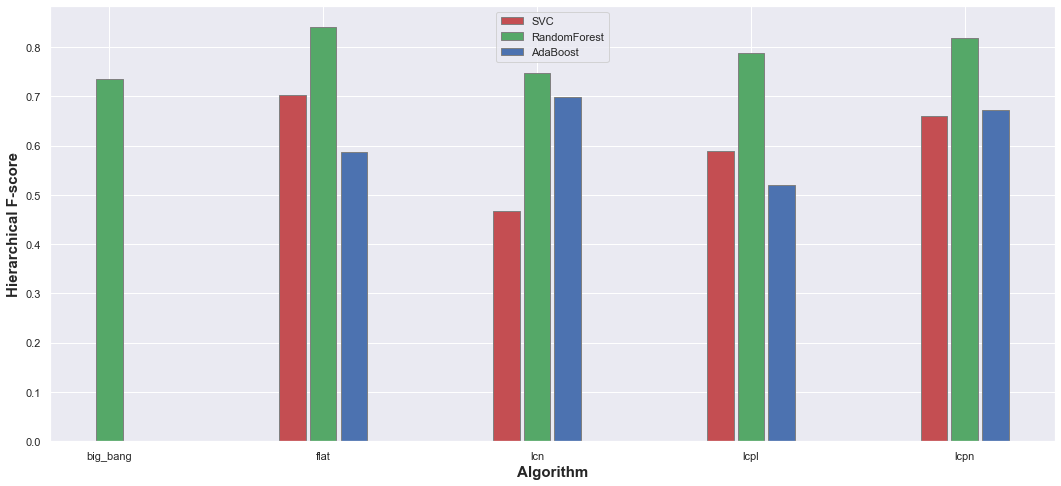

In [104]:
base_estimators_list = list(base_estimators_dict.keys())
clf_func_list = sorted(list(clf_func_dict.keys()))

barWidth = 0.125
fig = plt.subplots(figsize=(18, 8))
 
# set height of bar
svc = get_filtred_metrics(results_df, base_estimator=base_estimators_list[0])
rfc = get_filtred_metrics(results_df, base_estimator=base_estimators_list[1])
abc = get_filtred_metrics(results_df, base_estimator=base_estimators_list[2])
 
# Set position of bar on X axis 
br1 = np.arange(len(svc)) 
br2 = [x + barWidth*1.15 for x in br1] 
br3 = [x + barWidth*1.15 for x in br2]
 
# Make the plot
plt.bar(br1, svc, color='r', width=barWidth, 
        edgecolor='grey', label='SVC') 
plt.bar(br2, rfc, color='g', width=barWidth, 
        edgecolor='grey', label='RandomForest') 
plt.bar(br3, abc, color='b', width=barWidth, 
        edgecolor='grey', label='AdaBoost')
 
# Adding Xticks 
plt.xlabel('Algorithm', fontweight='bold', fontsize = 15) 
plt.ylabel('Hierarchical F-score', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth*1.15 for r in range(len(svc))], 
        clf_func_list)
 
plt.legend()
plt.show() 

## Podsumowanie

Flat Classification:
- no parent categories
- only leaf-level label
- Plusy:
    + prostota podejścia
    + łatwość wdrożenia
    + brak konieczności znajomości hierarchii klas
    + wcale nie takie złe wyniki
- Minusy:
    - utrata ważnych informacji - cennych właściwości klasyfikacyjnyhc
    - możliwe obniżenie wydajności

Big-Bang:
- klasyfikator globalny
- pojedynczy, stosunkowo złożony model
    - który bierze pod uwagę całą hierarchię klas jako całość, podczas jednego uruchomienia
- Plusy:
    + proste
- Minusy:
    - półgeneryczny algorytm
    - duża złożoność podejścia
    - rzadko używany
    - wyniki średnie

Lokalne klasyfikatory
- To podejście wykorzystuje pre-definiowaną taksonomię danych do tworzenia hierarchii klasyfikatorów
-  LCPN - Local classifier per parent node:
    - szkolenie jednego wieloklasowy klasyfikatora na każdy węzeł-rodzic, aby rozróżnić jego węzły-dzieci
    - Aby zapobiec niespójnościom z przewidywaniami na różnych poziomach, można zaprojektować system w taki sposób, aby przykład sklasyfikowany przez pierwszy klasyfikator jako „kot” był widoczny tylko dla klasyfikatora „Koty” na drugim poziomie
    - Plusy:
        + intuicyjna opcja
        + dość dobre wyniki
    - Minusy:
        - sporo klasyfikatorów - duża złożoność, ale to mniej niż w LCN
- LCN - Local classifier per node
    - uczenie jednego klasyfikatora binarnego dla każdego węzła w hierarchii (z wyłączeniem węzła „root”)
    - Plusy:
        + binarne klasyfikatory są proste w implementacji
    - Minusy:
        - duża liczba klasyfikatorów - duża złożoność
- LCL - Local classifier per level
    - szkolenie jednego klasyfikatora wieloklasowego dla każdego poziomu
    - To podejście jest powszechnie niepopularne, prawdopodobnie ze względu na problem niespójności
    - Plusy:
        + w miarę proste
    - Minusy:
        - na głębokich poziomach, może być wiele możliwych klas
        - mniej klasyfikatorów
        - niekonsekwencja bardzo prawdopodobna
        - nie uwzględnia relacji rodzic-dziecko

Klasyfikatory lokalne ogólnie
- Plusy:
    + jest wysoce intuicyjne
    + wykorzystuje informacje o hierarchii w danych
    + zachowując prostotę i ogólność (może być używane z dowolnym klasyfikatorem bazowym)
- Minusy
    - model końcowy może być duży
    - problem propagacji błędów
        - błąd na jednym poziomie wpływa na wszystkie następujące